In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 2 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


# 0. T=0, K=2, LCC

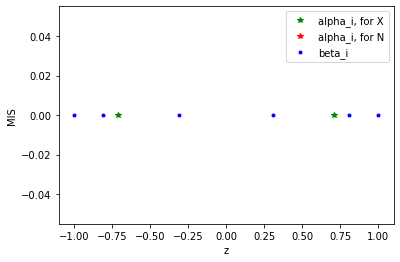

[ 0.70710678 -0.70710678]


In [10]:
K = 2
T = 0
Noise_Alloc = []
sigma = 1

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)



plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()

print(alpha_array)    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [15]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,5, 6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v0 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v0  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N==2:
            z_array = np.array([-0.88, 0.88])
        elif N ==4:
            z_array = np.array([-0.88, -0.25, 0.25, 0.88])
        elif N ==5:
            z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
        elif N ==6:
            z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
        elif N ==7:
            z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
        else:
            z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=True) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=True)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v0[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v0[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [-0.88  0.88]
@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 105.6888 
Accuracy: 5436/10000 (54.36%)

Round   0, Average loss 105.689 Test accuracy 54.360
selected users: [0 1]

Test set: Average loss: 4642.3198 
Accuracy: 6478/10000 (64.78%)

Round   1, Average loss 4642.320 Test accuracy 64.780
selected users: [0 1]

Test set: Average loss: 95315.9929 
Accuracy: 8283/10000 (82.83%)

Round   2, Average loss 95315.993 Test accuracy 82.830
selected users: [0 1]

Test set: Average loss: 362241.6422 
Accuracy: 8946/10000 (89.46%)

Round   3, Average loss 362241.642 Test accuracy 89.460
selected users: [0 1]

Test set: Average loss: 1356874.0032 
Accuracy: 8816/10000 (88.16%)

Round   4, Average loss 1356874.003 Test accuracy 88.160
selected users: [0 1]

Test set: Average loss: 3278420.0808 
Accuracy: 8764/10000 (87.64%)

Round   5, Average loss 3278420.081 Test accuracy 8


Test set: Average loss: 3204.1140 
Accuracy: 8525/10000 (85.25%)

Round  23, Average loss 3204.114 Test accuracy 85.250
selected users: [0 1 2 3]

Test set: Average loss: 3185.3759 
Accuracy: 8540/10000 (85.40%)

Round  24, Average loss 3185.376 Test accuracy 85.400
selected users: [0 1 2 3]

Test set: Average loss: 3121.3410 
Accuracy: 8532/10000 (85.32%)

Round  25, Average loss 3121.341 Test accuracy 85.320
selected users: [0 1 2 3]

Test set: Average loss: 3179.7011 
Accuracy: 8536/10000 (85.36%)

Round  26, Average loss 3179.701 Test accuracy 85.360
selected users: [0 1 2 3]

Test set: Average loss: 3226.2629 
Accuracy: 8530/10000 (85.30%)

Round  27, Average loss 3226.263 Test accuracy 85.300
selected users: [0 1 2 3]

Test set: Average loss: 3119.4796 
Accuracy: 8553/10000 (85.53%)

Round  28, Average loss 3119.480 Test accuracy 85.530
selected users: [0 1 2 3]

Test set: Average loss: 3145.9926 
Accuracy: 8543/10000 (85.43%)

Round  29, Average loss 3145.993 Test accuracy 85.4


Test set: Average loss: 1500.7943 
Accuracy: 8575/10000 (85.75%)

Round  17, Average loss 1500.794 Test accuracy 85.750
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1415.1229 
Accuracy: 8672/10000 (86.72%)

Round  18, Average loss 1415.123 Test accuracy 86.720
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1547.2439 
Accuracy: 8540/10000 (85.40%)

Round  19, Average loss 1547.244 Test accuracy 85.400
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1470.5413 
Accuracy: 8531/10000 (85.31%)

Round  20, Average loss 1470.541 Test accuracy 85.310
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1482.0266 
Accuracy: 8592/10000 (85.92%)

Round  21, Average loss 1482.027 Test accuracy 85.920
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1526.9165 
Accuracy: 8615/10000 (86.15%)

Round  22, Average loss 1526.917 Test accuracy 86.150
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1415.3664 
Accuracy: 8614/10000 (86.14%)

Round  23, Average loss 141

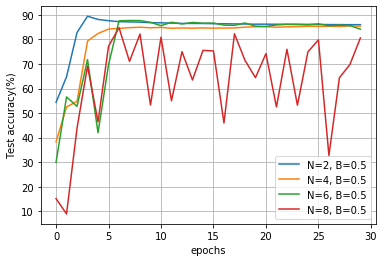

In [16]:
B_sel = 0

plt.plot(acc_test_arr_v0[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v0[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v0[3,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v0[4,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 0.1. K=2, T=0, BACC

In [20]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,5, 6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N==2:
            z_array = np.array([-0.88, 0.88])
        elif N ==4:
            z_array = np.array([-0.88, -0.25, 0.25, 0.88])
        elif N ==5:
            z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
        elif N ==6:
            z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
        elif N ==7:
            z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
        else:
            z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=False)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [-0.88  0.88]
@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 456.4302 
Accuracy: 5091/10000 (50.91%)

Round   1, Average loss 456.430 Test accuracy 50.910
selected users: [0 1]

Test set: Average loss: 17190.5733 
Accuracy: 6411/10000 (64.11%)

Round   2, Average loss 17190.573 Test accuracy 64.110
selected users: [0 1]

Test set: Average loss: 108696.9412 
Accuracy: 7226/10000 (72.26%)

Round   3, Average loss 108696.941 Test accuracy 72.260
selected users: [0 1]

Test set: Average loss: 474554.6232 
Accuracy: 8791/10000 (87.91%)

Round   4, Average loss 474554.623 Test accuracy 87.910
selected users: [0 1]

Test set: Average loss: 1527845.3360 
Accuracy: 8754/10000 (87.54%)

Round   5, Average loss 1527845.336 Test accuracy 87.540
selec


Test set: Average loss: 20541.1715 
Accuracy: 8516/10000 (85.16%)

Round  23, Average loss 20541.171 Test accuracy 85.160
selected users: [0 1 2 3]

Test set: Average loss: 20597.6707 
Accuracy: 8501/10000 (85.01%)

Round  24, Average loss 20597.671 Test accuracy 85.010
selected users: [0 1 2 3]

Test set: Average loss: 20698.6980 
Accuracy: 8500/10000 (85.00%)

Round  25, Average loss 20698.698 Test accuracy 85.000
selected users: [0 1 2 3]

Test set: Average loss: 20607.9558 
Accuracy: 8504/10000 (85.04%)

Round  26, Average loss 20607.956 Test accuracy 85.040
selected users: [0 1 2 3]

Test set: Average loss: 20628.2537 
Accuracy: 8509/10000 (85.09%)

Round  27, Average loss 20628.254 Test accuracy 85.090
selected users: [0 1 2 3]

Test set: Average loss: 20570.9734 
Accuracy: 8507/10000 (85.07%)

Round  28, Average loss 20570.973 Test accuracy 85.070
selected users: [0 1 2 3]

Test set: Average loss: 20574.8778 
Accuracy: 8508/10000 (85.08%)

Round  29, Average loss 20574.878 Test


Test set: Average loss: 251.5864 
Accuracy: 6738/10000 (67.38%)

Round  17, Average loss 251.586 Test accuracy 67.380
selected users: [0 1 2 3 4 5]

Test set: Average loss: 280.8088 
Accuracy: 6985/10000 (69.85%)

Round  18, Average loss 280.809 Test accuracy 69.850
selected users: [0 1 2 3 4 5]

Test set: Average loss: 259.9236 
Accuracy: 5992/10000 (59.92%)

Round  19, Average loss 259.924 Test accuracy 59.920
selected users: [0 1 2 3 4 5]

Test set: Average loss: 134.7649 
Accuracy: 7296/10000 (72.96%)

Round  20, Average loss 134.765 Test accuracy 72.960
selected users: [0 1 2 3 4 5]

Test set: Average loss: 197.5391 
Accuracy: 6141/10000 (61.41%)

Round  21, Average loss 197.539 Test accuracy 61.410
selected users: [0 1 2 3 4 5]

Test set: Average loss: 196.0376 
Accuracy: 6203/10000 (62.03%)

Round  22, Average loss 196.038 Test accuracy 62.030
selected users: [0 1 2 3 4 5]

Test set: Average loss: 252.9292 
Accuracy: 6970/10000 (69.70%)

Round  23, Average loss 252.929 Test acc

In [19]:
alpha_array[Signal_Alloc]

array([-0.58778525,  0.58778525])

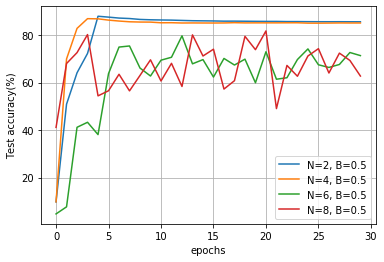

In [22]:
B_sel = 0

plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 0.2. K=2, T=0, BACC, original set of beta

alpha_array:  [ 0.70710678 -0.70710678] 

z_array:  [ 1.00000000e+00  7.07106781e-01  6.12323400e-17 -7.07106781e-01] 



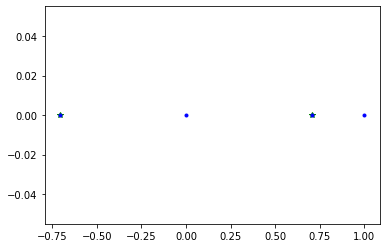

In [23]:
j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

N = 4
i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

plt.plot(alpha_array, np.zeros(K),'g*',label='alpha')
plt.plot(z_array, np.zeros(N),'b.',label='beta')


In [24]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v0_2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v0_2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=False)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v0_2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v0_2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [1.000000e+00 6.123234e-17]
@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 0.8166 
Accuracy: 6954/10000 (69.54%)

Round   1, Average loss 0.817 Test accuracy 69.540
selected users: [0 1]

Test set: Average loss: 0.1013 
Accuracy: 9725/10000 (97.25%)

Round   2, Average loss 0.101 Test accuracy 97.250
selected users: [0 1]

Test set: Average loss: 0.0929 
Accuracy: 9762/10000 (97.62%)

Round   3, Average loss 0.093 Test accuracy 97.620
selected users: [0 1]

Test set: Average loss: 0.0867 
Accuracy: 9780/10000 (97.80%)

Round   4, Average loss 0.087 Test accuracy 97.800
selected users: [0 1]

Test set: Average loss: 0.0920 
Accuracy: 9775/10000 (97.75%)

Round   5, Average loss 0.092 Test accuracy 97.750
selected users: [0 1]

Test set: Av


Test set: Average loss: 3478.9579 
Accuracy: 9213/10000 (92.13%)

Round  26, Average loss 3478.958 Test accuracy 92.130
selected users: [0 1 2 3]

Test set: Average loss: 3468.3672 
Accuracy: 9215/10000 (92.15%)

Round  27, Average loss 3468.367 Test accuracy 92.150
selected users: [0 1 2 3]

Test set: Average loss: 3427.8961 
Accuracy: 9165/10000 (91.65%)

Round  28, Average loss 3427.896 Test accuracy 91.650
selected users: [0 1 2 3]

Test set: Average loss: 3519.4784 
Accuracy: 9213/10000 (92.13%)

Round  29, Average loss 3519.478 Test accuracy 92.130
2
z_array: [ 1.00000000e+00  8.66025404e-01  5.00000000e-01  6.12323400e-17
 -5.00000000e-01 -8.66025404e-01]
@BACC_Enc: N,K,T, m_i= 6 2 0 30000 

@BACC_Enc: N,K,T, m_i= 6 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.4115 
Accuracy: 5030/10000 (50.30%)

Round   0, Average loss 1.411 Test accuracy 50.300
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.9366 
Accuracy: 553


Test set: Average loss: 75.8722 
Accuracy: 9174/10000 (91.74%)

Round  19, Average loss 75.872 Test accuracy 91.740
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 79.5093 
Accuracy: 9150/10000 (91.50%)

Round  20, Average loss 79.509 Test accuracy 91.500
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 81.6278 
Accuracy: 9167/10000 (91.67%)

Round  21, Average loss 81.628 Test accuracy 91.670
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 81.2135 
Accuracy: 9188/10000 (91.88%)

Round  22, Average loss 81.214 Test accuracy 91.880
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 85.2044 
Accuracy: 9153/10000 (91.53%)

Round  23, Average loss 85.204 Test accuracy 91.530
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 73.6711 
Accuracy: 9219/10000 (92.19%)

Round  24, Average loss 73.671 Test accuracy 92.190
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 82.0060 
Accuracy: 9176/10000 (91.76%)

Round  25, Average loss 82.00

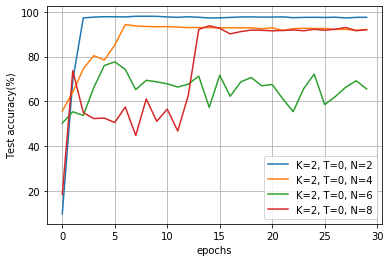

In [27]:
B_sel = 0

plt.plot(acc_test_arr_v0_2[0,B_sel,0,0:30],label='K=2, T=0, N=2')
plt.plot(acc_test_arr_v0_2[1,B_sel,0,0:30],label='K=2, T=0, N=4')
plt.plot(acc_test_arr_v0_2[2,B_sel,0,0:30],label='K=2, T=0, N=6')
plt.plot(acc_test_arr_v0_2[3,B_sel,0,0:30],label='K=2, T=0, N=8')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 0.3. BACC, original beta / alpha

In [7]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist1, CNNMnist2

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) + 0.01 #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
# N_array = [2,4,6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v0_4 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v0_4  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

loss_train_arr_v0_4 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_train_arr_v0_4  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist1(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=False)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_train, loss_train = test_img(net_glob, dataset_train, args)
                
                acc_train_arr_v0_4[N_idx][B_idx][trial_idx][iter] = acc_train
                loss_train_arr_v0_4[N_idx][B_idx][trial_idx][iter] = loss_train
                
                acc_test_arr_v0_4[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v0_4[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [1.000000e+00 6.123234e-17]
@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)


Test set: Average loss: 2.3026 
Accuracy: 5923/60000 (9.87%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)


Test set: Average loss: 2.3026 
Accuracy: 5923/60000 (9.87%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)


Test set: Average loss: 2.3026 
Accuracy: 5923/60000 (9.87%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 1.9221 
Accuracy: 3608/10000 (36.08%)


Test set: Average loss: 1.9244 
Accuracy: 21939/60000 (36.56%)

Round   3, Average loss 1.922 Test accuracy 36.080
selected users: [0 1]

Test set: Average loss: 0.9539 
Accura

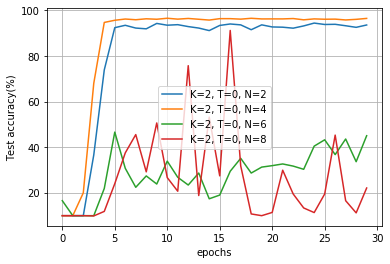

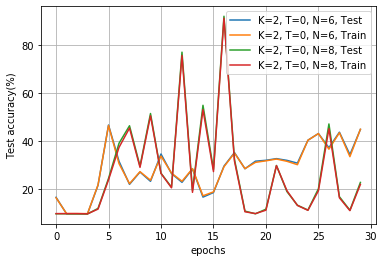

In [13]:
B_sel = 0

plt.plot(acc_train_arr_v0_4[0,B_sel,0,0:30],label='K=2, T=0, N=2')
plt.plot(acc_train_arr_v0_3[1,B_sel,0,0:30],label='K=2, T=0, N=4')
plt.plot(acc_train_arr_v0_3[2,B_sel,0,0:30],label='K=2, T=0, N=6')
plt.plot(acc_train_arr_v0_3[3,B_sel,0,0:30],label='K=2, T=0, N=8')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

plt.plot(acc_test_arr_v0_3[2,B_sel,0,0:30],label='K=2, T=0, N=6, Test')
plt.plot(acc_train_arr_v0_3[2,B_sel,0,0:30],label='K=2, T=0, N=6, Train')
plt.plot(acc_test_arr_v0_3[3,B_sel,0,0:30],label='K=2, T=0, N=8, Test')
plt.plot(acc_train_arr_v0_3[3,B_sel,0,0:30],label='K=2, T=0, N=8, Train')
# plt.plot(acc_test_arr_v0_3[2,B_sel,0,0:30],label='K=2, T=0, N=6')
# plt.plot(acc_test_arr_v0_3[3,B_sel,0,0:30],label='K=2, T=0, N=8')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 1. K=2, T=3, LCC

225 61 41 33 140


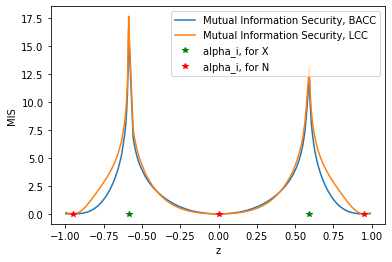

-0.9975830890921746 0.12711035873432933
-0.9961943757348031 0.12083371518736682
-0.9948680856557808 0.11492115074141385
-0.9930965040928621 0.10715655055640178
-0.9912442271311257 0.09921235483642246
-0.9880205312968382 0.08585022907082382
-0.9874582850240947 0.08358444564204899
-0.9867533054276589 0.08077211642577752
-0.9763237748281275 0.04342262613146283
-0.9717495558879794 0.029999887345388065
-0.9668651379799755 0.018053890176840587
-0.9550583760325975 0.0012397682939410822
-0.9539183773006601 0.000638020189434779
-0.9538296679444822 0.0005993698066429859
-0.9503468700442843 3.998713845795206e-05
-0.9467222821409358 0.0015195734808682165
-0.9438223770372289 0.004293826193333146
-0.9420568835800072 0.006701235921916011
-0.9397177612846306 0.01075234027133081
-0.9369849496910407 0.016760603911890617
-0.9344700776072556 0.023534859055034777
-0.930765517488672 0.03574409062991252
-0.9295661936081152 0.040276574161229074
-0.9262565512968108 0.05428054676298645
-0.923219150260155 0.0690

In [2]:
K = 2
T = 3
Noise_Alloc = [0,2,4]
sigma = 1

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 500
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_LCC_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [14]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))


# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,5, 6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N==2:
            z_array = np.array([-0.88, 0.88])
        elif N ==4:
            z_array = np.array([-0.88, -0.25, 0.25, 0.88])
        elif N ==5:
            z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
        elif N ==6:
            z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
        elif N ==7:
            z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
        else:
            z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma,_is_LCC=True))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=True) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=True)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [-0.88  0.88]


IndexError: index 3 is out of bounds for axis 0 with size 2

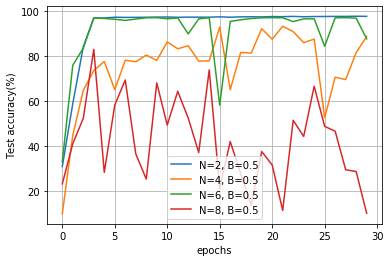

In [6]:
B_sel = 0

plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2. LCC, Sum-pooling

In [4]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,5, 6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N==2:
            z_array = np.array([-0.88, 0.88])
        elif N ==4:
            z_array = np.array([-0.88, -0.25, 0.25, 0.88])
        elif N ==5:
            z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
        elif N ==6:
            z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
        elif N ==7:
            z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
        else:
            z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma,_is_LCC=True))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=True) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist3(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=True)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [-0.88  0.88]
0.4790831073995587
0.4790831073995592
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 1.8067 
Accuracy: 8895/10000 (88.95%)

Round   1, Average loss 1.807 Test accuracy 88.950
selected users: [0 1]

Test set: Average loss: 0.8538 
Accuracy: 6965/10000 (69.65%)

Round   2, Average loss 0.854 Test accuracy 69.650
selected users: [0 1]

Test set: Average loss: 0.2424 
Accuracy: 9701/10000 (97.01%)

Round   3, Average loss 0.242 Test accuracy 97.010
selected users: [0 1]

Test set: Average loss: 0.2269 
Accuracy: 9747/10000 (97.47%)

Round   4, Average loss 0.227 Test accuracy 97.470
selected users: [0 1]

Test set: Average loss: 0.2042 
Accuracy: 9756/10000 (97.56%)

Round   5, Average loss 0.204 Test accuracy 97.560
selected us


Test set: Average loss: 1.8120 
Accuracy: 9616/10000 (96.16%)

Round  27, Average loss 1.812 Test accuracy 96.160
selected users: [0 1 2 3]

Test set: Average loss: 1.7956 
Accuracy: 9659/10000 (96.59%)

Round  28, Average loss 1.796 Test accuracy 96.590
selected users: [0 1 2 3]

Test set: Average loss: 1.7923 
Accuracy: 9625/10000 (96.25%)

Round  29, Average loss 1.792 Test accuracy 96.250
2
z_array: [-0.88 -0.25 -0.2   0.25  0.88]
0.4790831073995587
0.49582278866316015
0.28002344758060876
0.4958227886631595
0.4790831073995592
@BACC_Enc: N,K,T, m_i= 5 2 3 30000 

@BACC_Enc: N,K,T, m_i= 5 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1 2 3 4]

Test set: Average loss: 74.1690 
Accuracy: 1989/10000 (19.89%)

Round   0, Average loss 74.169 Test accuracy 19.890
selected users: [0 1 2 3 4]

Test set: Average loss: 32.7955 
Accuracy: 991/10000 (9.91%)

Round   1, Average loss 32.796 Test accuracy 9.910
selected users: [0 1 2 3 4]

Test set: Average loss: 73.8825 
Accurac


Test set: Average loss: 0.7540 
Accuracy: 9745/10000 (97.45%)

Round  21, Average loss 0.754 Test accuracy 97.450
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.7854 
Accuracy: 9759/10000 (97.59%)

Round  22, Average loss 0.785 Test accuracy 97.590
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.8064 
Accuracy: 9762/10000 (97.62%)

Round  23, Average loss 0.806 Test accuracy 97.620
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.8723 
Accuracy: 9440/10000 (94.40%)

Round  24, Average loss 0.872 Test accuracy 94.400
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.7925 
Accuracy: 9724/10000 (97.24%)

Round  25, Average loss 0.792 Test accuracy 97.240
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.7480 
Accuracy: 9742/10000 (97.42%)

Round  26, Average loss 0.748 Test accuracy 97.420
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.8075 
Accuracy: 9722/10000 (97.22%)

Round  27, Average loss 0.807 Test accuracy 97.220
selected users:

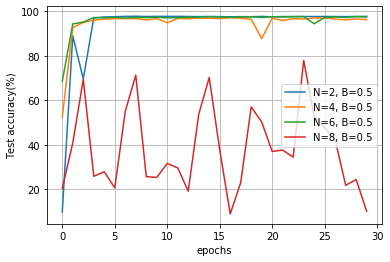

In [7]:
B_sel = 0

plt.plot(acc_test_arr_v2[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v2[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v2[3,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v2[4,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [13]:
K = 2
T = 3
Noise_Alloc = [0,2,4]
sigma = 1

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

print(alpha_array)

[ 9.51056516e-01  5.87785252e-01  6.12323400e-17 -5.87785252e-01
 -9.51056516e-01]


# 4. K=6, N=15, BACC

In [26]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [27]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist1, CNNMnist2

from utils.functions import *
import math

K = 6
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) + 0.01 #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [6,9,12,15,20]
# N_array = [2,4,6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K6_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K6_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

loss_train_arr_K6_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_train_arr_K6_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist1(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                
#                 acc_train, loss_train = test_img(net_glob, dataset_train, args)
                
#                 acc_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = acc_train
#                 loss_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = loss_train
                
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                
                acc_test_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [ 1.00000000e+00  8.66025404e-01  5.00000000e-01  6.12323400e-17
 -5.00000000e-01 -8.66025404e-01]
@BACC_Enc: N,K,T, m_i= 6 6 0 10000 

@BACC_Enc: N,K,T, m_i= 6 6 0 10000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3018 
Accuracy: 1028/10000 (10.28%)

Round   3, Average loss 2.302 Test accuracy 10.280
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.1143 
Accuracy: 6044/10000 (60.44%)

Round   4, Average loss 2.114 Test accuracy 60.440
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.6697 
Accu


Test set: Average loss: 1.4855 
Accuracy: 9606/10000 (96.06%)

Round  23, Average loss 1.486 Test accuracy 96.060
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4933 
Accuracy: 9602/10000 (96.02%)

Round  24, Average loss 1.493 Test accuracy 96.020
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4760 
Accuracy: 9603/10000 (96.03%)

Round  25, Average loss 1.476 Test accuracy 96.030
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4793 
Accuracy: 9603/10000 (96.03%)

Round  26, Average loss 1.479 Test accuracy 96.030
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4609 
Accuracy: 9599/10000 (95.99%)

Round  27, Average loss 1.461 Test accuracy 95.990
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4796 
Accuracy: 9598/10000 (95.98%)

Round  28, Average loss 1.480 Test accuracy 95.980
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 1.4819 
Accuracy: 9617/10000 (96.17%)

Round  29, Average loss 1.482 


Test set: Average loss: 1.9962 
Accuracy: 9326/10000 (93.26%)

Round   9, Average loss 1.996 Test accuracy 93.260
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0050 
Accuracy: 9406/10000 (94.06%)

Round  10, Average loss 2.005 Test accuracy 94.060
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.9862 
Accuracy: 9376/10000 (93.76%)

Round  11, Average loss 1.986 Test accuracy 93.760
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.9915 
Accuracy: 9389/10000 (93.89%)

Round  12, Average loss 1.992 Test accuracy 93.890
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0077 
Accuracy: 9418/10000 (94.18%)

Round  13, Average loss 2.008 Test accuracy 94.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.9959 
Accuracy: 9381/10000 (93.81%)

Round  14, Average loss 1.996 Test accuracy 93


Test set: Average loss: 2.2237 
Accuracy: 9223/10000 (92.23%)

Round  21, Average loss 2.224 Test accuracy 92.230
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Test set: Average loss: 2.2147 
Accuracy: 9236/10000 (92.36%)

Round  22, Average loss 2.215 Test accuracy 92.360
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Test set: Average loss: 2.2158 
Accuracy: 9402/10000 (94.02%)

Round  23, Average loss 2.216 Test accuracy 94.020
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Test set: Average loss: 2.2200 
Accuracy: 9323/10000 (93.23%)

Round  24, Average loss 2.220 Test accuracy 93.230
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Test set: Average loss: 2.2220 
Accuracy: 9293/10000 (92.93%)

Round  25, Average loss 2.222 Test accuracy 92.930
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Test set: Average loss: 2.2183 
Ac

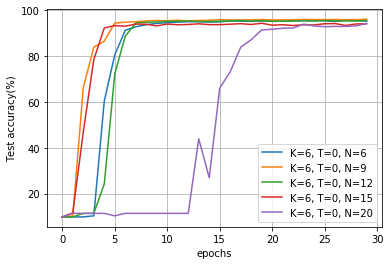

In [30]:
B_sel = 0
# N_array = 
# N_array = [6,9,12,15]

plt.plot(acc_test_arr_K6_v1[0,B_sel,0,0:30],label='K=6, T=0, N=6')
plt.plot(acc_test_arr_K6_v1[1,B_sel,0,0:30],label='K=6, T=0, N=9')
plt.plot(acc_test_arr_K6_v1[2,B_sel,0,0:30],label='K=6, T=0, N=12')
plt.plot(acc_test_arr_K6_v1[3,B_sel,0,0:30],label='K=6, T=0, N=15')
plt.plot(acc_test_arr_K6_v1[4,B_sel,0,0:30],label='K=6, T=0, N=20')
# plt.plot(acc_test_arr_K3_v1[4,B_sel,0,0:30],label='N=13, K=4')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 5. K=3

In [16]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 3 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [19]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist1, CNNMnist2

from utils.functions import *
import math

K = 3
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) + 0.01 #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,6,8]
# N_array = [2,4,6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K3_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K3_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))


for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist1(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                
#                 acc_train, loss_train = test_img(net_glob, dataset_train, args)
                
#                 acc_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = acc_train
#                 loss_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = loss_train
                
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                
                acc_test_arr_K3_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K3_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [1.000000e+00 6.123234e-17]
@BACC_Enc: N,K,T, m_i= 2 3 0 20000 

@BACC_Enc: N,K,T, m_i= 2 3 0 20000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 1.1776 
Accuracy: 5478/10000 (54.78%)

Round   2, Average loss 1.178 Test accuracy 54.780
selected users: [0 1]

Test set: Average loss: 0.6460 
Accuracy: 7604/10000 (76.04%)

Round   3, Average loss 0.646 Test accuracy 76.040
selected users: [0 1]

Test set: Average loss: 0.6753 
Accuracy: 7678/10000 (76.78%)

Round   4, Average loss 0.675 Test accuracy 76.780
selected users: [0 1]

Test set: Average loss: 0.4897 
Accuracy: 8367/10000 (83.67%)

Round   5, Average loss 0.490 Test accuracy 83.670
selected users: [0 1]

Test set: Avera


Test set: Average loss: 0.2311 
Accuracy: 9698/10000 (96.98%)

Round  27, Average loss 0.231 Test accuracy 96.980
selected users: [0 1 2 3]

Test set: Average loss: 0.2433 
Accuracy: 9696/10000 (96.96%)

Round  28, Average loss 0.243 Test accuracy 96.960
selected users: [0 1 2 3]

Test set: Average loss: 0.2427 
Accuracy: 9666/10000 (96.66%)

Round  29, Average loss 0.243 Test accuracy 96.660
2
z_array: [ 1.00000000e+00  8.66025404e-01  5.00000000e-01  6.12323400e-17
 -5.00000000e-01 -8.66025404e-01]
@BACC_Enc: N,K,T, m_i= 6 3 0 20000 

@BACC_Enc: N,K,T, m_i= 6 3 0 20000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3003 
Accuracy: 2015/10000 (20.15%)

Round   1, Average loss 2.300 Test accuracy 20.150
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.1046 
Accuracy: 9304/10000 (93.04%)

Round


Test set: Average loss: 2.0886 
Accuracy: 9527/10000 (95.27%)

Round  20, Average loss 2.089 Test accuracy 95.270
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1473 
Accuracy: 9507/10000 (95.07%)

Round  21, Average loss 2.147 Test accuracy 95.070
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1205 
Accuracy: 9654/10000 (96.54%)

Round  22, Average loss 2.121 Test accuracy 96.540
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0282 
Accuracy: 9616/10000 (96.16%)

Round  23, Average loss 2.028 Test accuracy 96.160
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1415 
Accuracy: 9550/10000 (95.50%)

Round  24, Average loss 2.141 Test accuracy 95.500
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1509 
Accuracy: 9520/10000 (95.20%)

Round  25, Average loss 2.151 Test accuracy 95.200
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0567 
Accuracy: 9564/10000 (95.64%)

Round  26, Average loss 2.057 Test accurac

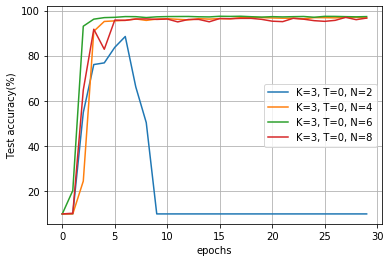

In [31]:
B_sel = 0
# N_array = [2,4,6,8]

plt.plot(acc_test_arr_K3_v1[0,B_sel,0,0:30],label='K=3, T=0, N=2')
plt.plot(acc_test_arr_K3_v1[1,B_sel,0,0:30],label='K=3, T=0, N=4')
plt.plot(acc_test_arr_K3_v1[2,B_sel,0,0:30],label='K=3, T=0, N=6')
plt.plot(acc_test_arr_K3_v1[3,B_sel,0,0:30],label='K=3, T=0, N=8')
# plt.plot(acc_test_arr_K3_v1[4,B_sel,0,0:30],label='N=13, K=4')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 6. K=4

In [20]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 4 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [22]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist1, CNNMnist2

from utils.functions import *
import math

K = 4
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) + 0.01 #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,7,10,13]
# N_array = [2,4,6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))


for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist1(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                
#                 acc_train, loss_train = test_img(net_glob, dataset_train, args)
                
#                 acc_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = acc_train
#                 loss_train_arr_K6_v1[N_idx][B_idx][trial_idx][iter] = loss_train
                
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                
                acc_test_arr_K4_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [1.000000e+00 6.123234e-17]
@BACC_Enc: N,K,T, m_i= 2 4 0 15000 

@BACC_Enc: N,K,T, m_i= 2 4 0 15000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   4, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   5, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.3


Test set: Average loss: 0.2901 
Accuracy: 9538/10000 (95.38%)

Round  28, Average loss 0.290 Test accuracy 95.380
selected users: [0 1 2 3]

Test set: Average loss: 0.3178 
Accuracy: 9552/10000 (95.52%)

Round  29, Average loss 0.318 Test accuracy 95.520
2
z_array: [ 1.          0.90096887  0.6234898   0.22252093 -0.22252093 -0.6234898
 -0.90096887]
@BACC_Enc: N,K,T, m_i= 7 4 0 15000 

@BACC_Enc: N,K,T, m_i= 7 4 0 15000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2870 
Accuracy: 3268/10000 (32.68%)

Round   1, Average loss 2.287 Test accuracy 32.680
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 1.2075 
Accuracy: 6894/10000 (68.94%)

Round   2, Average loss 1.207 Test accuracy 68.940
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 0.8554 
Accuracy: 7640/10000 (76.40%)

Round 


Test set: Average loss: 1.0148 
Accuracy: 7550/10000 (75.50%)

Round  20, Average loss 1.015 Test accuracy 75.500
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.1022 
Accuracy: 7412/10000 (74.12%)

Round  21, Average loss 1.102 Test accuracy 74.120
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.1318 
Accuracy: 7614/10000 (76.14%)

Round  22, Average loss 1.132 Test accuracy 76.140
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.1220 
Accuracy: 7301/10000 (73.01%)

Round  23, Average loss 1.122 Test accuracy 73.010
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.1069 
Accuracy: 8173/10000 (81.73%)

Round  24, Average loss 1.107 Test accuracy 81.730
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.1077 
Accuracy: 7631/10000 (76.31%)

Round  25, Average loss 1.108 Test accuracy 76.310
selected users: [0 1 2 3 4 5 6 7 8 9]

Test set: Average loss: 1.0484 
Accuracy: 7540/10000 (75.40%)

Round  26, Average

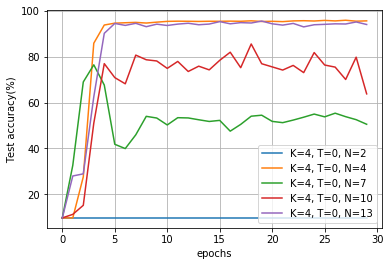

In [32]:
B_sel = 0
# N_array = [2,4,7,10,13]

plt.plot(acc_test_arr_K4_v1[0,B_sel,0,0:30],label='K=4, T=0, N=2')
plt.plot(acc_test_arr_K4_v1[1,B_sel,0,0:30],label='K=4, T=0, N=4')
plt.plot(acc_test_arr_K4_v1[2,B_sel,0,0:30],label='K=4, T=0, N=7')
plt.plot(acc_test_arr_K4_v1[3,B_sel,0,0:30],label='K=4, T=0, N=10')
plt.plot(acc_test_arr_K4_v1[4,B_sel,0,0:30],label='K=4, T=0, N=13')
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()